In [2]:
!pip install rasterio geopandas pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 61.4 MB/s eta 0:00:00


Download the data files that will be needed from the GitHub repo

In [23]:
!wget https://raw.githubusercontent.com/acesillinois/cpsc444-F2025/refs/heads/main/datasets/Iris.csv
!wget https://raw.githubusercontent.com/acesillinois/cpsc444-F2025/refs/heads/main/datasets/Set2data.csv
!wget https://raw.githubusercontent.com/acesillinois/cpsc444-F2025/refs/heads/main/datasets/Set4.2EC.csv
!wget https://raw.githubusercontent.com/acesillinois/cpsc444-F2025/refs/heads/main/datasets/caelev.tif

--2025-08-27 19:29:47--  https://raw.githubusercontent.com/acesillinois/cpsc444-F2025/refs/heads/main/datasets/Iris.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5107 (5.0K) [text/plain]
Saving to: ‘Iris.csv.2’

Iris.csv.2          100%[===================>]   4.99K  --.-KB/s    in 0s      

2025-08-27 19:29:48 (44.7 MB/s) - ‘Iris.csv.2’ saved [5107/5107]

--2025-08-27 19:29:48--  https://raw.githubusercontent.com/acesillinois/cpsc444-F2025/refs/heads/main/datasets/Set2data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

# Spatial Plotting — Python Conversion
Example Spatial Operations

In [3]:
import rasterio, geopandas as gpd, pandas as pd, matplotlib.pyplot as plt
from shapely.geometry import Point

## Load raster

In [5]:
with rasterio.open('caelev.tif') as src:
    raster=src.read(1); bounds=src.bounds; crs=src.crs

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


## Load points CSV and subset

In [6]:
df=pd.read_csv('Set2data.csv')
df_sub=df[df['ID']%10==0]
gdf=gpd.GeoDataFrame(df_sub, geometry=gpd.points_from_xy(df_sub.Longitude, df_sub.Latitude), crs='EPSG:4326')

## Plot

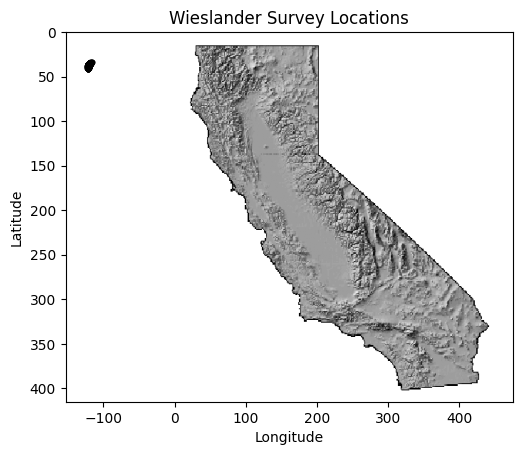

In [7]:
fig,ax=plt.subplots()
left,bottom,right,top=bounds
ax.imshow(raster,extent=(left,right,bottom,top),origin='upper',cmap='gray')
gdf.plot(ax=ax,markersize=10,color='black')
ax.set_title('Wieslander Survey Locations'); ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
plt.show()

In [9]:
!pip install pykrige

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.7/961.7 kB 8.9 MB/s eta 0:00:00


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.optimize import curve_fit

try:
    from pykrige.ok import OrdinaryKriging
    PYKRIGE_AVAILABLE = True
except Exception as _e:
    PYKRIGE_AVAILABLE = False
    print('PyKrige not available. You can install it with: %pip install pykrige')


In [11]:
px_size = 10
csv_path = 'Set4.2EC.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError('Missing Set4.2EC.csv. Place it in the working directory.')

df = pd.read_csv(csv_path)
required = {'Easting','Northing','ECto30'}
missing = required - set(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}')

# Create ID like in R and subset every px_size-th row
df['ID'] = np.arange(1, len(df)+1)
df_sub = df[df['ID'] % px_size == 0].copy()

X = df_sub['Easting'].to_numpy()
Y = df_sub['Northing'].to_numpy()
Z = df_sub['ECto30'].to_numpy()
len(X), df_sub.head()

(1200,
      Longitude   Latitude  ECto30  ECto100     Easting   Northing  ID
 9  -121.934860  38.551270    27.2     69.9  592813.250  4267520.0  10
 19 -121.934859  38.551436    26.8     66.1  592813.063  4267538.5  20
 29 -121.934857  38.551544    24.7     63.0  592812.875  4267550.5  30
 39 -121.934856  38.551727    27.4     66.6  592813.313  4267571.0  40
 49 -121.943017  38.554474    31.3     55.9  592098.500  4267867.5  50)

In [12]:
bb = {'N': 4267868, 'S': 4267513, 'E': 592867, 'W': 592082}
grid_x = np.arange(bb['W'], bb['E'] + px_size, px_size)
grid_y = np.arange(bb['S'], bb['N'] + px_size, px_size)
len(grid_x), len(grid_y)

(80, 37)

## Empirical variogram and spherical model fit
We compute an empirical semi-variogram and fit a spherical model:

$\gamma(h) = nugget + sill \cdot S(h; a)$

where

$S(h; a) = 1.5 (h/a) - 0.5 (h/a)^3$

for $0 < h < a$,

and $1$ for $h \ge a$.

($a$ is the range; beyond it the variogram reaches the sill + nugget.)


In [16]:
def empirical_variogram(x, y, z, n_bins=20, max_dist=None):
    xy = np.column_stack([x, y])
    D = distance.pdist(xy)
    if max_dist is None:
        max_dist = np.percentile(D, 90)  # trim long tails
    # idx = distance.squareform(np.arange(len(xy)))  # not used
    # Semivariance for pairs
    Z = z
    # Build all pairwise semivariances
    # Efficient approach: compute condensed distance matrix and pairwise semivariances
    # But scipy doesn't directly give condensed semivariances, so we compute indices
    n = len(Z)
    vals = []
    dists = []
    for i in range(n-1):
        dz = (Z[i+1:] - Z[i])
        d = distance.cdist(xy[i:i+1], xy[i+1:]).ravel()
        m = d <= max_dist
        if np.any(m):
            dists.append(d[m])
            vals.append(0.5 * dz[m]**2)
    if not dists:
        raise RuntimeError('Not enough pairs within max_dist for variogram.')
    dists = np.concatenate(dists)
    vals = np.concatenate(vals)

    bins = np.linspace(0, max_dist, n_bins+1)
    bin_centers = 0.5*(bins[:-1] + bins[1:])
    gamma = np.full(n_bins, np.nan)
    for i in range(n_bins):
        m = (dists >= bins[i]) & (dists < bins[i+1])
        if m.any():
            gamma[i] = np.mean(vals[m])
    m = np.isfinite(gamma)
    return bin_centers[m], gamma[m]

def spherical_model(h, sill, a, nugget):
    h = np.asarray(h)
    g = np.empty_like(h, dtype=float)
    # piecewise
    ha = h / a
    inside = h < a
    g[inside] = nugget + sill * (1.5*ha[inside] - 0.5*ha[inside]**3)
    g[~inside] = nugget + sill
    return g

Fitted variogram params -> sill: 11.201692881836566  range: 356.0035090566949  nugget: 9.460317265290902


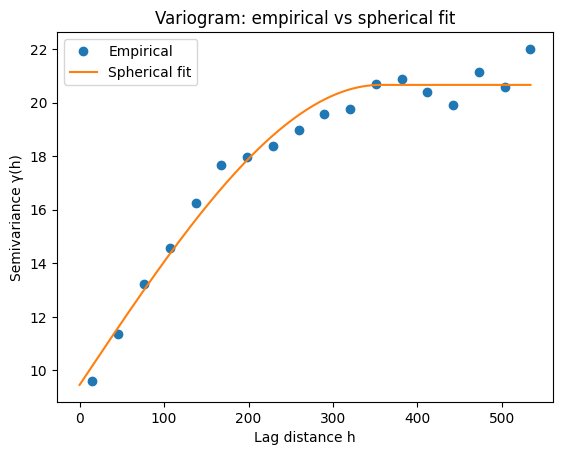

In [17]:
# Estimate empirical variogram
h_emp, gamma_emp = empirical_variogram(X, Y, Z, n_bins=18)

# Fit spherical model with bounds
p0 = [np.nanmax(gamma_emp)*0.8, (np.max(h_emp)/2) or 1.0, np.nanmin(gamma_emp)*0.1]
bounds = ([1e-6, 1.0, 0.0], [np.inf, np.max(h_emp)*2, np.nanmax(gamma_emp)])
pars, cov = curve_fit(spherical_model, h_emp, gamma_emp, p0=p0, bounds=bounds, maxfev=20000)
sill_hat, range_hat, nugget_hat = pars
print('Fitted variogram params -> sill:', sill_hat, ' range:', range_hat, ' nugget:', nugget_hat)

# Plot empirical vs fitted variogram
hh = np.linspace(0, h_emp.max(), 200)
plt.figure()
plt.plot(h_emp, gamma_emp, 'o', label='Empirical')
plt.plot(hh, spherical_model(hh, *pars), '-', label='Spherical fit')
plt.xlabel('Lag distance h')
plt.ylabel('Semivariance γ(h)')
plt.title('Variogram: empirical vs spherical fit')
plt.legend()
plt.show()

## Ordinary Kriging
We use `PyKrige` with the fitted spherical parameters. If PyKrige is not available, the cell will prompt an install command.


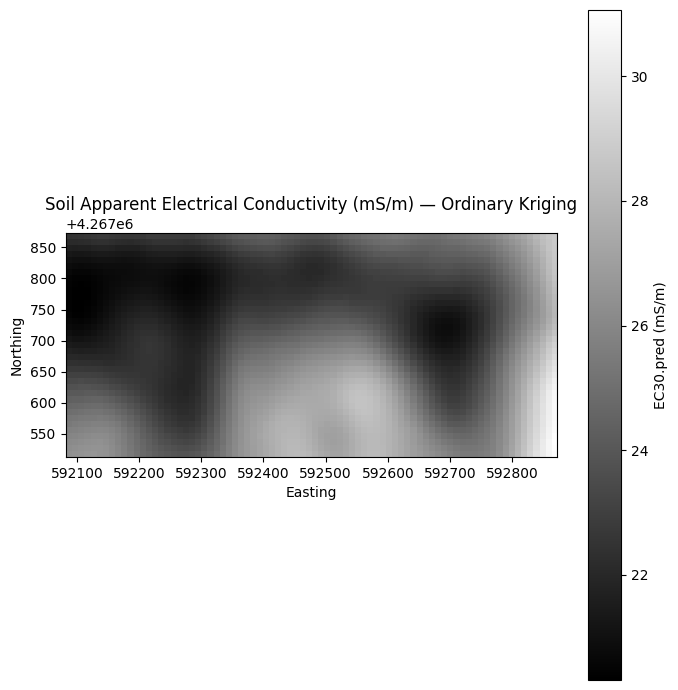

In [20]:
if not PYKRIGE_AVAILABLE:
    raise ModuleNotFoundError('PyKrige not installed. Install with: %pip install pykrige')

# PyKrige expects parameters [sill, range, nugget]
OK = OrdinaryKriging(
    X, Y, Z,
    variogram_model='spherical',
    variogram_parameters=[float(sill_hat), float(range_hat), float(nugget_hat)],
    enable_plotting=False,
    coordinates_type='euclidean'
)

# Execute on grid (like R's prediction grid); grid expects vectors of x and y
z_krig, ss_krig = OK.execute('grid', grid_x.astype(float), grid_y.astype(float))

# z_krig is shape (len(grid_y), len(grid_x)); plot in grayscale with axes and title
extent = (grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max())
plt.figure(figsize=(7,7))
plt.imshow(z_krig, origin='lower', extent=extent, cmap='gray')
plt.colorbar(label='EC30.pred (mS/m)')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Soil Apparent Electrical Conductivity (mS/m) — Ordinary Kriging')
plt.tight_layout()
plt.show()